In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta
import itertools
from sklearn.linear_model import LinearRegression 
from scipy.stats import t

# Reading and Cleaning the Data

First thing's first, import the Attendance Register file into a dataframe. 

In [3]:
attendance=pd.read_csv("Attendance Register.csv")

The first two (non-index) columns of the dataframe are actually student id and name, even though they appear as "Unnamed: n" in the dataframe itself. Since I am only concerned with overall attendance trends in my class, I'm going to annonymize the data and drop both of these columns. Before doing that, they will be a bit helpful in cleaning the data so we should name them fisrt. Then I'm going to drop all the rows where the name is null since those rows are either course id's or a key for understanding the "U, A, E" monickers in the date columns. 

In [4]:
attendance=attendance.rename(columns={'Unnamed: 0' : 'id', 'Unnamed: 1': "Name"})

In [5]:
attendance=attendance.drop(attendance[attendance.Name.isna()].index)

In [6]:
attendance=attendance.drop(columns=["id", "Name"])

Double check now to make sure that I only have attendance data for students (and the day of the week that each date is on). The day of the week data will be helpful for later, so we're going to keep it in for now.

In [7]:
attendance.head()

,08/17/23,08/18/23,08/19/23,08/20/23,08/21/23,08/22/23,08/23/23,08/24/23,08/25/23,08/26/23,...,01/04/24,01/05/24,01/06/24,01/07/24,01/08/24,01/09/24,01/10/24,01/11/24,01/12/24,Unnamed: 151
0,Thu,Fri,Sat,Sun,Mon,Tue,Wed,Thu,Fri,Sat,...,Thu,Fri,Sat,Sun,Mon,Tue,Wed,Thu,Fri,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN
3,U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,U,NaN,NaN,NaN,A,NaN,U,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
attendance.columns

Index(['08/17/23', '08/18/23', '08/19/23', '08/20/23', '08/21/23', '08/22/23',
       '08/23/23', '08/24/23', '08/25/23', '08/26/23',
       ...
       '01/04/24', '01/05/24', '01/06/24', '01/07/24', '01/08/24', '01/09/24',
       '01/10/24', '01/11/24', '01/12/24', 'Unnamed: 151'],
      dtype='object', length=150)

There is another column at the end that I missed that is also unnamed. I'm going to renname it to 'unknown' so I can separately access it, and check if it contains anything (I find that using df.column doesn't like it when the column name has a number at the end).

In [9]:
attendance=attendance.rename(columns={'Unnamed: 151': 'unknown'})

In [10]:
attendance.unknown

0     NaN
2     NaN
3     NaN
4     NaN
5     NaN
       ..
131   NaN
132   NaN
133   NaN
134   NaN
135   NaN
Name: unknown, Length: 129, dtype: float64

This looks like a lot of NaN's, but I want to make sure so let's do a quick count.

In [11]:
attendance.unknown.count()

0

So basically everything in here is NaN. This may be because this column had information regarding the class code or the absence key, but that's not important for what I'm doing. In any case, it's safe to just drop thie column.

In [12]:
attendance=attendance.drop(columns=['unknown'])

Speaking of, the attendance dataframe uses 'U' for an unexcused absence, 'A' for an excused absence, 'X' for an exempt absence, and '-' for "not on roster on this date". The NaN values are recorded when the student is present. Because I don't want to factors students not on my roster in various computations, it'll be easier to replace the existing NaN values with "P" for present and the '-' values with NaN.

In [13]:
attendance=attendance.fillna('P')
attendance=attendance.replace('-', np.NaN)
attendance['08/19/23'].value_counts()

P      118
Sat      1
Name: 08/19/23, dtype: int64

Just checking here to see what 8/19 looks like, it turns out that this attendance register also recorded weekends and (I presume) holidays. So the next thing is to drop those columns from the dataframe since no one is expecting students to show up on those days.

In [16]:
#Gathering up all of the weekends to drop them from the dataframe
date_list=list(attendance.columns)
weekends=[]
for date in date_list:
    if attendance[date][0] in ['Sat', 'Sun']:
        weekends.append(date)
#Drop all weekends in place
attendance.drop(columns=weekends, inplace=True)

Now we need to drop other days that students were not expected to show. I was just lazy with this and recorded these dates directly from the school calendar.

In [17]:
breaks=["09/04/23", '10/20/23', '10/24/23', '11/22/23', '11/23/23', '11/24/23', '11/27/23', '12/05/23']

In [18]:
# This is where I ponder scraping data from the school calendar and somehow using datetime to drop holidays for me.
breaks.append('12/21/23')
breaks.append('12/22/23')
breaks.append('12/25/23')
breaks.append('12/26/23')
breaks.append('12/27/23')
breaks.append('12/28/23')
breaks.append('12/29/23')
breaks.append('01/01/24')
breaks.append('01/02/24')

In [19]:
#Drop all breaks
attendance.drop(columns=breaks, inplace=True)

In [20]:
attendance.head()

,08/17/23,08/18/23,08/21/23,08/22/23,08/23/23,08/24/23,08/25/23,08/28/23,08/29/23,08/30/23,...,12/19/23,12/20/23,01/03/24,01/04/24,01/05/24,01/08/24,01/09/24,01/10/24,01/11/24,01/12/24
0,Thu,Fri,Mon,Tue,Wed,Thu,Fri,Mon,Tue,Wed,...,Tue,Wed,Wed,Thu,Fri,Mon,Tue,Wed,Thu,Fri
2,P,P,P,P,P,P,P,P,P,P,...,P,P,P,P,P,P,U,P,P,P
3,U,P,P,P,P,P,P,P,P,P,...,X,P,P,P,U,P,A,P,U,P
4,P,P,P,P,P,P,P,P,P,P,...,P,U,P,P,P,P,P,P,P,P
5,P,P,P,P,P,P,P,P,P,P,...,X,P,P,P,P,P,P,P,P,P


That looks better in terms of instructional days (we have 90 instructional days per semester). Continuing the cleaning, note that we have dates as our columns, but they're represented by strings. In order to better plot time-series data, I'm going to convert the columns to datetime objects.

In [21]:
#Apply a function to the columns to convert them to datetime objects inplace
attendance.rename(columns=lambda x : datetime.strptime(x, "%m/%d/%y"), inplace=True)

Now I want to find how often each student was present, absent, etc. So I'm going to apply value_counts to each row (except for the "day" row) and make a new dataframe out of that.

In [25]:
student_attendance=attendance.drop([0]).apply(pd.Series.value_counts,axis=1).fillna(0)
student_attendance.head()

,A,P,T,U,X
2,4.0,79.0,0.0,7.0,0.0
3,3.0,76.0,0.0,10.0,1.0
4,0.0,80.0,0.0,10.0,0.0
5,1.0,87.0,0.0,1.0,1.0
6,4.0,74.0,0.0,11.0,1.0


In particular, I'm concerned with how often they had excused or unexcused absences. Since I'm only concerned about absences, I will count tardy students as being present.

In [30]:
#Excused absences are those where the student is marked "Absent" or "Exempt"
student_attendance['Excused']=student_attendance[['A','X']].sum(axis=1)

In [31]:
#This is not necessary, but I like descriptive names
student_attendance.rename(columns={'U': 'Unexcused'}, inplace=True)

In [32]:
#As mentioned earlier, as long as they made it to class, I'm counting them as present.
student_attendance['Present']=student_attendance[['P','T']].sum(axis=1)

In [33]:
#It's not strictly necessary to create a new dataframe here, but I want to write the previous one to csv later.
student_attendance_summarized=student_attendance[['Present', 'Excused', 'Unexcused']]

In [34]:
student_attendance_summarized

,Present,Excused,Unexcused
2,79.0,4.0,7.0
3,76.0,4.0,10.0
4,80.0,0.0,10.0
5,87.0,2.0,1.0
6,74.0,5.0,11.0
...,...,...,...
131,79.0,6.0,5.0
132,59.0,12.0,19.0
133,74.0,10.0,6.0
134,87.0,3.0,0.0


# Analyzing Student Absences

## Student Absence Rate

Now we want to get an idea of how many students were "chronically absent", which would be those students who miss more than 10% of days. Of course, we can whether we count excused absences as absences for this purpose. From the perspective of the student and determining fault, it may be better to not count excused absences. From the perspective of teaching being easier if the student is in class, it would be better to count excused absences as an absence. So let's do both!

In [36]:
#The percentage of days each student was absent (unexcused)
student_absence_unexcused=(student_attendance_summarized.Unexcused/90)*100

In [37]:
#sorting unexcused absence percent just to take a look at what the extreme values are
student_absence_unexcused.sort_values(ascending=False)

29     28.888889
48     27.777778
132    21.111111
108    20.000000
59     20.000000
         ...    
77      0.000000
129     0.000000
7       0.000000
134     0.000000
36      0.000000
Name: Unexcused, Length: 128, dtype: float64

While not completely unexpected, it is telling that I have several students who missed over a fifth of instructional days. On the other hand, I'm really glad that there are at least five students who did not miss a day unexcused. Now let's see how many of my students were chronically absent in the fall semester.

In [38]:
student_absence_unexcused[student_absence_unexcused>10.0].count()

32

Since I only have 128 students on my roster, that means that a quarter of my students were chronically absent (going by unexcused absences). It's worth noting that I teach in a somewhat rural area, so some of these unexcused absences may be the result of an inability to go to a doctor and get a note. Unfortunately, I do not have access to the sort of data that would give me a good idea of how much that impacts the unexcused absence number. Now let's look at absences in general.

In [39]:
student_absence=(1-student_attendance_summarized.Present/90)*100

In [40]:
student_absence[student_absence>10.0].count()

57

Note that 57 of my 128 students (45%) missed at least 10% of the instructional time! Regardless of why that happened, this makes it difficult to actually make progress in class. Let's take a look at some summary statistics for both series.

In [41]:
student_absence.describe()

count    128.000000
mean      11.449653
std        8.437303
min        0.000000
25%        5.555556
50%        9.444444
75%       16.666667
max       45.555556
Name: Present, dtype: float64

In [42]:
student_absence_unexcused.describe()

count    128.000000
mean       7.083333
std        5.807917
min        0.000000
25%        2.222222
50%        5.555556
75%       10.277778
max       28.888889
Name: Unexcused, dtype: float64

As we can see, there is at least one significant outlier for absence data. It may be worth creating a histogram here to bettwe visualize the data, but that's for another time. I also want to point out that this does not necessarily accurately generalize to the rest of the school since my roster isn't determined randomly, and misses significant chunks of the school population. For instance, I only teach gen-ed classes, among which are statistics classes that can be taken for college credit. This means that point estimates of the mean aren't exactly reliable here.

## Attendance by Date

The next thing I want to do is look at how many students are absent (just unexcused and absent in general) on my roster on each day. For this, we just need to count values across columns.

In [43]:
#For each date, count the number of students who are present or tardy to 
#get the number of folks who were present on that day.
present_bydate=((attendance=='P') | (attendance=='T')).sum()

In [44]:
#For each date, count the number of students who are absent (unexcused) on a given day.
unexcused_bydate=(attendance=='U').sum()

In [45]:
present_bydate

2023-08-17    115
2023-08-18    117
2023-08-21    112
2023-08-22    113
2023-08-23    116
             ... 
2024-01-08    118
2024-01-09    107
2024-01-10    118
2024-01-11    116
2024-01-12    116
Length: 90, dtype: int64

In [46]:
unexcused_bydate

2023-08-17     2
2023-08-18     1
2023-08-21     6
2023-08-22     4
2023-08-23     3
              ..
2024-01-08    10
2024-01-09    13
2024-01-10     7
2024-01-11     9
2024-01-12     9
Length: 90, dtype: int64

In [47]:
#percent of roster that is absent (unexcused)
unexcused_percent_bydate=unexcused_bydate.apply(lambda x : 100*(x/128))

In [48]:
unexcused_percent_bydate

2023-08-17     1.56250
2023-08-18     0.78125
2023-08-21     4.68750
2023-08-22     3.12500
2023-08-23     2.34375
                ...   
2024-01-08     7.81250
2024-01-09    10.15625
2024-01-10     5.46875
2024-01-11     7.03125
2024-01-12     7.03125
Length: 90, dtype: float64

Now we want to get a look at what the attendance looks like throughout the semester in my classes. We'll look at both unexcused absences and absences in general.

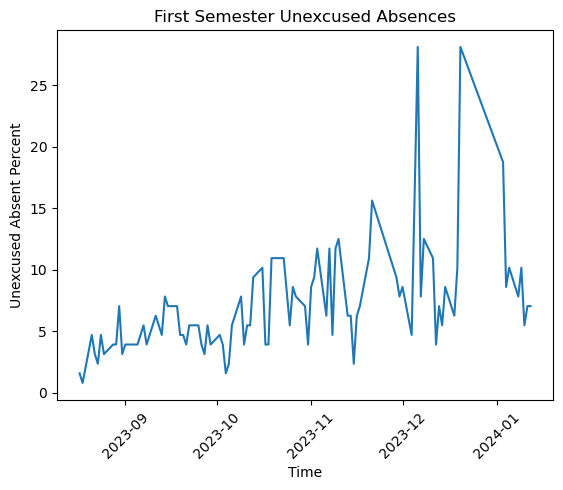

In [49]:
#Time-series graph of percent of unexcused absences during first semester.
plt.plot(unexcused_percent_bydate)
# Add title and axis labels
plt.title('First Semester Unexcused Absences')
plt.xlabel('Time')
plt.ylabel('Unexcused Absent Percent')
plt.xticks(rotation=45)

# Display the plot
plt.show()

A couple of things stand out here: The first is that there seems to be some tendency for students to be absent more often later in the semester. The second is that there are some massive spikes in december, which are likely related to holidays. Now here's the downside of having used timeseries data and dropping holidays: That large peak in january is likely due to one data-point before the winter break, and one data-point after the winter break. So this looks much more extreme than it actually is. We'll dig into this a bit later. For now, let's look at regular absences.

In [52]:
absent_bydate=128-present_bydate
absent_percent_bydate=100*(absent_bydate/128)

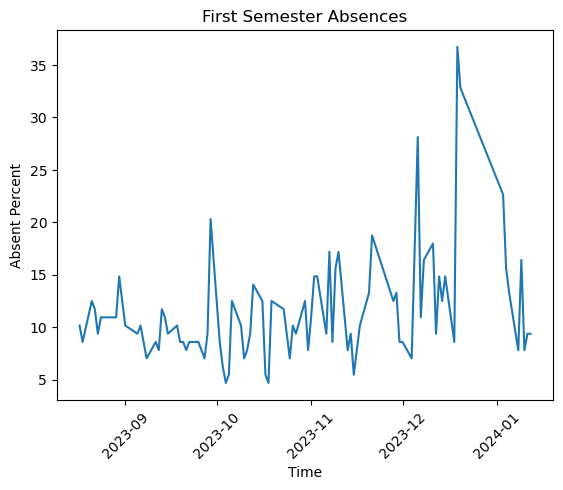

In [53]:
plt.plot(absent_percent_bydate)
# Add title and axis labels
plt.title('First Semester Absences')
plt.xlabel('Time')
plt.ylabel('Absent Percent')
plt.xticks(rotation=45)

# Display the plot
plt.show()

This looks much more sporadic, and less indicative of any trends. The larger hill at the beginning, for example, may be due to a COVID outbreak near the beginning of the year. In fact, it seems like counting excused absences may be causing too much noise from illnesses and other such things. Let's actually look at just those absences that are excused:

In [57]:
excused_bydate=absent_bydate-unexcused_bydate
excused_percent_bydate=100*(excused_bydate/128)

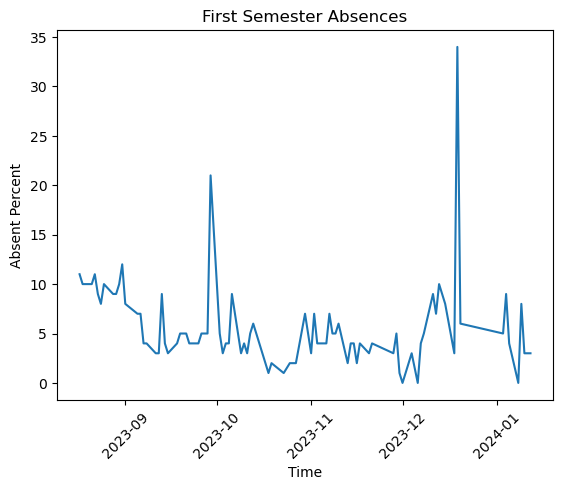

In [58]:
plt.plot(excused_bydate)
# Add title and axis labels
plt.title('First Semester Absences')
plt.xlabel('Time')
plt.ylabel('Absent Percent')
plt.xticks(rotation=45)

# Display the plot
plt.show()

This points as where some of the noise is coming from. Interestingly enough, outside of the large spikes, we have something that looks roughly (very roughly) periodic which may just be indicative of the fact that there's some sort of "bug" going around every so often. The two large spikes are almost certainly due to holidays or closures at home schools (I work at a career center that pulls from 8 different schools in the surrounding area) while the large hill at the beginnig can be attributed to a COVID outbreak. All in all, it seems to be erroneous to combine unexcused and excused absences if one is seeking to find some trends in student attendance. Though it is certainly viable for complaining about students not being in class!

Now we're going to grab some summary statistics to see if anything really stands out

In [54]:
absent_percent_bydate.describe()

count    90.000000
mean     11.449653
std       5.307956
min       4.687500
25%       8.593750
50%      10.156250
75%      12.500000
max      36.718750
dtype: float64

In [55]:
unexcused_percent_bydate.describe()

count    90.000000
mean      7.083333
std       4.511258
min       0.781250
25%       3.906250
50%       6.250000
75%       8.593750
max      28.125000
dtype: float64

# Regrouping the Data by Week/Day of the week

Now I'm curious as to whether or not there are trends in the data in regards to days of the week. For example, are students more likely to miss Firday or Monday? 

In [212]:
#create an array of the days of the weeks in date order
day_array=attendance.iloc[0].to_numpy()

In [213]:
#create an array of the present data in date order
present_array=present_bydate.to_numpy()

In [214]:
#create an array of unexcused absence data in date order
unexcused_array=unexcused_bydate.to_numpy()

Now we're going to make a dataframe that uses the dates as indeces with columns for: the day of the week, number of present students, and number of absent students. The ideas is that this will more easily allow us to partition the data into days of the week, and then reorganize that data by school week (we often use school week to indicate how far along we are into the semester).

In [215]:
d={'day': day_array, 'present' : present_array, 'unexcused' : unexcused_array}
attendance_days=pd.DataFrame(data=d, index=unexcused_bydate.index)

In [216]:
#create a dictionary to store the days of the week
day_dict={}
for wday in set(attendance_days.day.values):
    #zero out attendance for any date that does not correspond to the day we're considering
    day_present=attendance_days.present*(attendance_days.day==wday)
    #eliminate all 0 values
    day_dict[wday]=day_present[day_present.to_numpy().nonzero()[0]]

In [217]:
#End result is a dictionary that partitions the dates into days of the week.
day_dict

{'Mon': 2023-08-21    112
 2023-08-28    114
 2023-09-11    117
 2023-09-18    115
 2023-09-25    117
 2023-10-02    117
 2023-10-09    115
 2023-10-16    112
 2023-10-23    113
 2023-10-30    112
 2023-11-06    116
 2023-11-13    118
 2023-11-20    111
 2023-12-04    119
 2023-12-11    105
 2023-12-18    117
 2024-01-08    118
 dtype: int64,
 'Tue': 2023-08-22    113
 2023-08-29    114
 2023-09-05    116
 2023-09-12    118
 2023-09-19    117
 2023-09-26    118
 2023-10-03    120
 2023-10-10    119
 2023-10-17    121
 2023-10-31    118
 2023-11-07    106
 2023-11-14    116
 2023-11-21    104
 2023-11-28    112
 2023-12-12    116
 2023-12-19     81
 2024-01-09    107
 dtype: int64,
 'Wed': 2023-08-23    116
 2023-08-30    109
 2023-09-06    115
 2023-09-13    113
 2023-09-20    117
 2023-09-27    119
 2023-10-04    122
 2023-10-11    118
 2023-10-18    122
 2023-10-25    119
 2023-11-01    114
 2023-11-08    117
 2023-11-15    121
 2023-11-29    111
 2023-12-06     92
 2023-12-13    109

In [218]:
#Do the same for unexcused absences
day_dict_u={}
for wday in set(attendance_days.day.values):
    day_u=attendance_days.unexcused*(attendance_days.day==wday)
    day_dict_u[wday]=day_u[day_u.to_numpy().nonzero()[0]]

In [219]:
#Check summary statistics to see if there are any noticeable trends.
for wday in day_dict_u:
    print(wday, day_dict_u[wday].describe(), sep='\n')

Mon
count    17.000000
mean      9.117647
std       2.997548
min       5.000000
25%       7.000000
50%       8.000000
75%      10.000000
max      14.000000
dtype: float64
Tue
count    17.000000
mean      8.176471
std       4.746516
min       4.000000
25%       5.000000
50%       5.000000
75%      13.000000
max      20.000000
dtype: float64
Wed
count    19.000000
mean     10.473684
std      10.178236
min       2.000000
25%       5.500000
50%       7.000000
75%      10.000000
max      36.000000
dtype: float64
Fri
count    18.000000
mean      9.166667
std       4.287465
min       1.000000
25%       5.500000
50%       9.000000
75%      11.750000
max      16.000000
dtype: float64
Thu
count    19.000000
mean      8.315789
std       3.528497
min       2.000000
25%       6.500000
50%       8.000000
75%      10.500000
max      15.000000
dtype: float64


One thing that immediately pops out is Wednesday with it's fairly high standard deviation relative to the other days as well as the relatively higher mean. We can see from the data that Wednesday was one of those large spikes in absences that we saw near the end of the semester. Next, we wanto to visually compare the data. As the data is stored, this would yield timeseries graphs, but that may not be the best way to view the data.

Text(0.5, 0, 'Date')

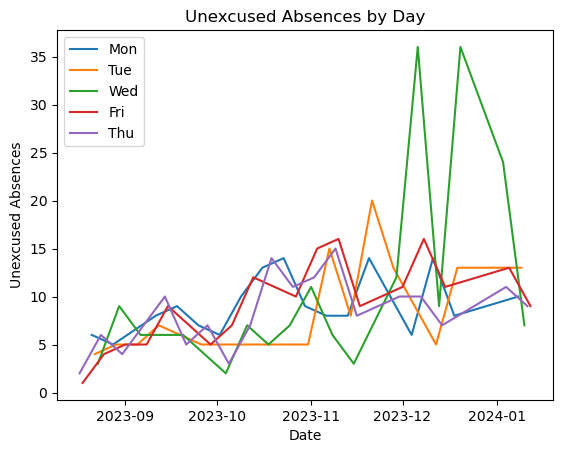

In [220]:
for wday in day_dict_u:
    plt.plot(day_dict_u[wday], label=wday)
plt.legend(loc="upper left")
plt.title('Unexcused Absences by Day')
plt.ylabel('Unexcused Absences')
plt.xlabel('Date')

We see the predicted spike, but the problem here is date may not be the best way to group these observations. A better method may be to group the date by which school week it is. This would also acount for the facts that we did not meet on every day of every week (so some school weeks will only include a subset of the weekdays). 

In [221]:
#Set the initial day to Sunday of the first week of school
week=timedelta(weeks=1)
initial=datetime(2023, 8, 13)

Now we're going to create a "school week" array to associate to each date. That will allow us to create a new dataframe with the school week as our index and days of the week as the columns. At the same time, I'm also going to store the "week of" data. Both pieces are useful to have even though they are easily derivable from each other: The week number more directly tells you how far into the semester you are, while the "week of" tells you about the surrounding events. So sometimes it may be useful to visualize data in terms of one or the other.

In [222]:
weekdays=['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
w_n=1
weeknum=[]
week_of=[]
date_prev=initial
date_check=initial+week
for date in attendance_days.index:
    #check if the date is within the week
    if date<=date_check:
        weeknum.append(w_n)
        week_of.append(date_prev)
    #if it isn't, keep incrementing the check date by a week until we end up at the appropriate week
    else:
        while date>date_check:
            w_n+=1
            date_prev=date_check
            date_check+=week
        weeknum.append(w_n)
        week_of.append(date_prev)

attendance_days["week number"]=weeknum
attendance_days["week of"]=week_of

In [223]:
#Join the week number to each day's unexcused absence series and make it a dataframe in the process
unex_weeknum={}
for wday in weekdays:
    unex_weeknum[wday]=day_dict_u[wday].rename(wday).to_frame().join(attendance_days[["week number"]])
    

In [224]:
#set the index of each weekday dataframe to its week number
for wday in weekdays:
    unex_weeknum[wday].set_index("week number", inplace=True)

In [225]:
#join all of the individual days of the week into a dataframe that organizes absences by school week
unexcused_by_week=unex_weeknum["Mon"].join(unex_weeknum["Tue"], how="outer")
unexcused_by_week=unexcused_by_week.join(unex_weeknum["Wed"], how="outer")
unexcused_by_week=unexcused_by_week.join(unex_weeknum["Thu"], how="outer")
unexcused_by_week=unexcused_by_week.join(unex_weeknum["Fri"], how="outer")

In [226]:
#quickly create a new dataframe with the unique values of "week of" and "week number", and then join that to the unexcused dataframe
weekof=pd.DataFrame(data=attendance_days["week of"].unique(), index=attendance_days["week number"].unique(), columns=["week of"])
unexcused_by_week=weekof.join(unexcused_by_week, how="outer")

In [227]:
unexcused_by_week

,week of,Mon,Tue,Wed,Thu,Fri
1,2023-08-13,NaN,NaN,NaN,2.0,1.0
2,2023-08-20,6.0,4.0,3.0,6.0,4.0
3,2023-08-27,5.0,5.0,9.0,4.0,5.0
4,2023-09-03,NaN,5.0,6.0,7.0,5.0
5,2023-09-10,8.0,7.0,6.0,10.0,9.0
6,2023-09-17,9.0,6.0,6.0,5.0,7.0
7,2023-09-24,7.0,5.0,4.0,7.0,5.0
8,2023-10-01,6.0,5.0,2.0,3.0,7.0
9,2023-10-08,10.0,5.0,7.0,7.0,12.0
10,2023-10-15,13.0,5.0,5.0,14.0,NaN


Now that we have everything arranged by week, we can take a look at the mean number of absences per day each week.

In [228]:
x=np.linspace(1,22, num=21)
y=unexcused_by_week.drop(columns=["week of"]).mean(axis=1)

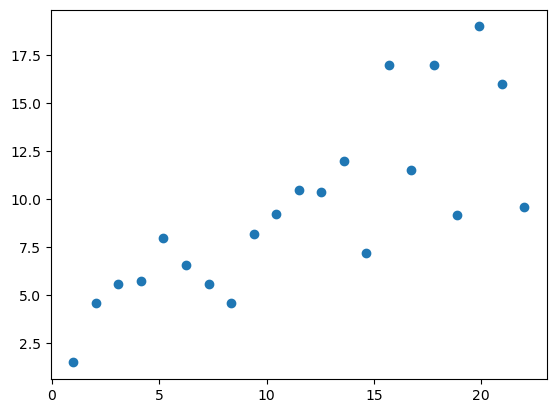

In [229]:
plt.scatter(x, y)

Interestingly enough, the scatterplot by week does suggest a linear relation moreso than the original timeseries data. Though, the statement "students tend to miss more school as the semester drags on" isn't exactly news. With that said, let's perform a simple linear regression.

In [237]:
x=pd.DataFrame(x)
reg=LinearRegression().fit(x,y)
reg.score(x,y)

0.6249416532760198

In [238]:
#create an array of x-values so we can apply the slope and intercept above.
y_pred=x*reg.coef_+reg.intercept_

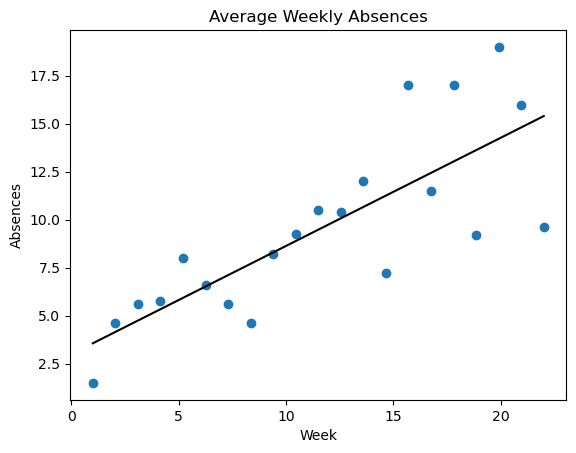

In [239]:
#recreate the scatter plot, but now with the line of best fit.
plt.scatter(x,y)
plt.plot(x, y_pred, color='black')
plt.title('Average Weekly Absences')
plt.xlabel('Week')
plt.ylabel('Absences')


plt.show()

Now, let's go ahead and test the significance of the relationship between the week and absences. In particular, we're going to use the slop $\beta_1$ to test this relationship.

$H_0: \beta_1=0$

$H_a:\beta_1\neq 0$

The first step is to compute the residual sum of squares (RSS).

In [244]:
#We have to send y and y_pred to arrays before zipping and using list comprehension
RSS=sum([(yi-y_hat)**2 for yi, y_hat in zip(y.to_numpy(), y_pred.to_numpy())])[0]
RSS

161.78418614718618

Since we don't know our population standard deviaion ($\sigma$), we estimate it with the residual standard error (RSE) in order to compute the test statistic.

In [245]:
RSE=math.sqrt(RSS/(len(x)-2))
RSE

2.9180399527150715

Assuming the null hypothesis, we compute the test-statistic noting that we're testing with the t-distribution with $n-2$ degrees of freedom.

In [246]:
#The t-value is just beta_1 divided by the standard error.
sqr_dev=(x-x.mean())**2
SE=RSE/math.sqrt(sqr_dev.sum())
t_val=reg.coef_/SE
t_val[0]

5.6266139553323145

Finally, we compute the p-value using the t-distribution from the scipy.stats library. Since we're doing a two-tailed test, we need the sum of both tails.

In [247]:
p=(1-t.cdf(t_val[0], len(x)-2))*2
print(p)

2.00066035673796e-05


We can very safely reject the null hypothesis here to conclude that it's highly likely that attendance is correlated with how far one is into the school year. Of course, we could have intuitively concluded that from the strength of the correlation and the value of $\beta_1$, but I had never done hypothesis testing in Python. So I figured this would be a nice motivator.

Now that we have our data arranged by school weeks and weekdays, we can now create a stacked bar chart where the x-axis is the school week and the stacked bars correspond to days of the week.

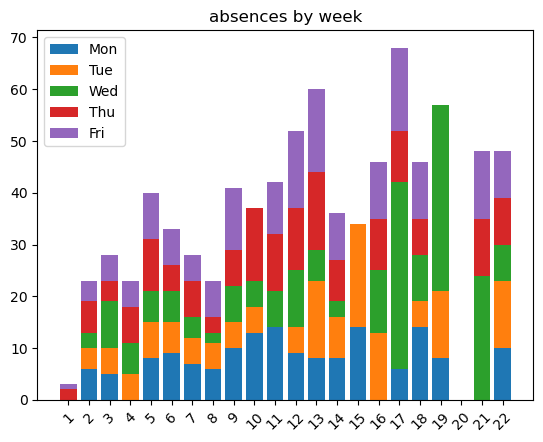

In [248]:
fig, ax = plt.subplots()
bottom=np.zeros(21)

bar_dict={}

#create a dictionary of values for each weekday so we can easily set the bar height
for wday in weekdays:
    bar_dict[wday]=unexcused_by_week[wday].values
    
for wday in bar_dict:
    ax.bar(unexcused_by_week.index, bar_dict[wday], bottom=bottom, label=wday)
    bottom+=np.nan_to_num(bar_dict[wday])

ax.set_title("absences by week")
ax.legend(loc="upper left")
plt.xticks(np.arange(1, 23, step=1.0))
plt.xticks(rotation=45)

plt.show()

Here, we can see that the weird spikes on Wednesdays come from weeks 17, 19, and 21. So we can check the dataframe for those weeks in particular

In [249]:
unexcused_by_week.loc[[17,19,21]]

,week of,Mon,Tue,Wed,Thu,Fri
17,2023-12-03,6.0,NaN,36.0,10.0,16.0
19,2023-12-17,8.0,13.0,36.0,NaN,NaN
21,2023-12-31,NaN,NaN,24.0,11.0,13.0


So that's Wednesday of the week of Dec 3rd, Dec 17th, and Dec 31. For the latter two dates, those are the days right before and right after breaks (given that the Wednesday bar was the last and first on those weeks in the stacked bar chart). For the first week, let's check what day that is (the week of date is always a Sunday).

In [250]:
#add three days to the "week of" date for week 17
unexcused_by_week.loc[17, "week of"]+timedelta(days=3)

Timestamp('2023-12-06 00:00:00')

I probably could have checked the school calendar, but I was being a bit lazy here. I do remember that this day was a "job shadow day for our seniors. That means that they had to find someone to job shadow and submit a form indicating that they were actually doing this, or they were marked absent. So really all this means is that a large portion of our seniors failed to fill out the form (for one reason or another). As this has little to with classroom attendance, it seems pertinent to set that value to NaN.

In [251]:
unexcused_by_week.at[17, "Wed"]=np.nan
#Checking that the replacement was done in place
unexcused_by_week.at[17, "Wed"]

nan

Now that we've done this, we probably should rerun some of the analysis we did above. This suggests that I should clean up this code in this notebook and create some functions, but that's for a later time. For now, I just went ahead and reran the appropriate cells above to check that the correlation was still statistically significant. It was, but slightly less so.

For fun, let's just compute the R^2 for simple linear regression on each pair of weekday absences.

In [252]:
weekday_pairs=list(filter( lambda p : p[0]!=p[1], list(itertools.product(weekdays, weekdays))))

In [253]:
unexcused_by_week_filled=unexcused_by_week

In [254]:
for wday in weekdays:
    wday_mean=unexcused_by_week_filled[wday].mean()
    unexcused_by_week_filled[wday].fillna(wday_mean, inplace=True)


In [255]:
for p in weekday_pairs:
    x=unexcused_by_week_filled[[p[0]]]
    y=unexcused_by_week_filled[p[1]]
    reg=LinearRegression().fit(x,y)
    print(p, reg.score(x,y))

('Mon', 'Tue') 0.07705954444912444
('Mon', 'Wed') 0.0001950682757143607
('Mon', 'Thu') 0.10530594708424923
('Mon', 'Fri') 0.02760387236181938
('Tue', 'Mon') 0.07705954444912477
('Tue', 'Wed') 0.10571133849772663
('Tue', 'Thu') 0.09927040625414885
('Tue', 'Fri') 0.07914483267632555
('Wed', 'Mon') 0.00019506827571447172
('Wed', 'Tue') 0.1057113384977264
('Wed', 'Thu') 0.02073509907339577
('Wed', 'Fri') 0.04925341328741217
('Thu', 'Mon') 0.1053059470842489
('Thu', 'Tue') 0.09927040625414907
('Thu', 'Wed') 0.0207350990733961
('Thu', 'Fri') 0.5654628464067637
('Fri', 'Mon') 0.027603872361820048
('Fri', 'Tue') 0.07914483267632555
('Fri', 'Wed') 0.049253413287412284
('Fri', 'Thu') 0.5654628464067637


Funnily enough, there seems to be little relationship between absences on most days of the week. That is, there does not seem to be a strong linear relationship between absences on e.g. Monday and Tuesday of a given week. It is somewhat funny that there is such a relationship between absences on Thursdays Fridays. 